In [109]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, multilabel_confusion_matrix
import pandas_profiling
from sklearn.preprocessing import Normalizer, normalize
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# Functions

In [110]:
# Построение графика roc_auc score
def roc_auc_print(y,probs): 
    fpr, tpr, threshold = roc_curve(y, probs)
    roc_auc = roc_auc_score(y, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
# Построение графика бинарных признаков
def bin_plot(col):
    labels = list(df.query('sample == 1 and default == 1')[col].value_counts().index)
    X = np.arange(2)

    fig, ax = plt.subplots(figsize=(10, 7))

    plt.figure(figsize=(20, 5))
    rects1 = ax.bar(X + 0.00, df.query('sample == 1')[col].value_counts(), width = 0.35)
    rects2 = ax.bar(X + 0.25, df.query('sample == 1').groupby('default')[col].value_counts()[1], color = 'r', width = 0.25)
    ax.set_xticks(X)
    x = np.arange(len(labels))
    ax.set_xticklabels(labels)
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    fig.tight_layout()
    plt.show()
    print('Доля дефолта от общего количества','\n',df.query('sample == 1 and default == 1')[col].value_counts()/
          df.query('sample == 1')[col].value_counts())

In [111]:
df_train = pd.read_csv('../input/sf-dst-scoring/train.csv')
df_test = pd.read_csv('../input/sf-dst-scoring/test.csv')
sample_submission = pd.read_csv('../input/sf-dst-scoring/sample_submission.csv')

In [112]:
# Для удобной работы объеденим train и test, пометим 1 и 0 соответственно. Целевой показатель в test отметим -1
df_train['sample'] = 1
df_test['sample'] = 0
df_test['default'] = -1
df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
df.shape

(110148, 20)

In [113]:
df_test.shape,sample_submission.shape

((36349, 20), (24354, 2))

In [114]:
df_test.dropna().shape

(36178, 20)

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

# Предобработка


### Преобразуем дату в формат date

In [116]:
df.app_date = df.app_date.apply(lambda x: pd.to_datetime(x) if x!=None else x)

### Заполнение пропусков в education отложим

# EDA & Featuring engineering

### client_id

In [117]:
# удостоверимся в уникальности
print(df.client_id.unique().shape)
# Удалим колонку
df = df.drop('client_id', axis=1)

(110148,)


### app_date
Попробуем сгенерировать несколько признаков и в дальнейшем проверим их влияние на модель.

In [118]:
print(df.app_date.max(),df.app_date.min())
df['date_month'] = df.app_date.dt.month
df['date_date'] = df.app_date.dt.day
df['date_week'] = df.app_date.dt.dayofweek

2014-04-30 00:00:00 2014-01-01 00:00:00


Данные за 4 месяца с января 2014 по конец апреля 2014

### Sex,car,car_type,good_work,foreign_passport
Проверим на бинарность и создадим список бинарных признаков

In [119]:
bin_cat =[]
for i in df:
    if len(df[i].value_counts()) == 2 and i != 'sample':
        bin_cat.append(i)
        print(i)

sex
car
car_type
good_work
foreign_passport


#### sex

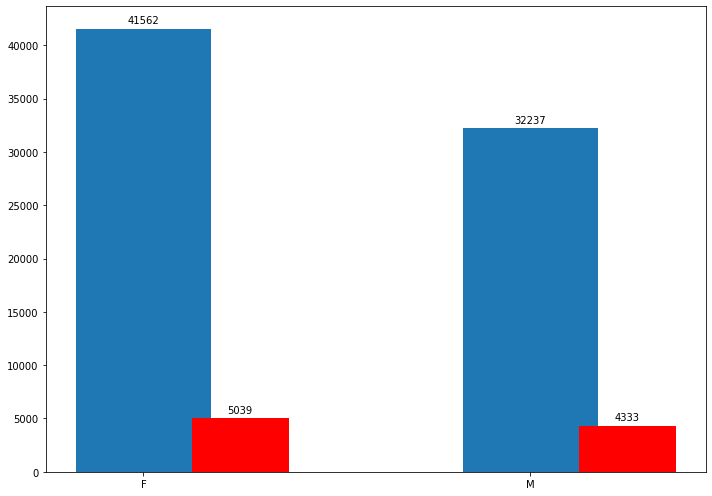

<Figure size 1440x360 with 0 Axes>

Доля дефолта от общего количества 
 F    0.121241
M    0.134411
Name: sex, dtype: float64


In [120]:
bin_plot('sex')

Доля дефолта по М и Ж чуть больше 1%; 13% и 12% соответственно. Можно сказать, что дефолт среди мужчин немного больше чем у женщин, однако, в количественном выражении мужчин меньше. Пол заемщика, на основании представленных данных, не влияет на дефолт.

#### car

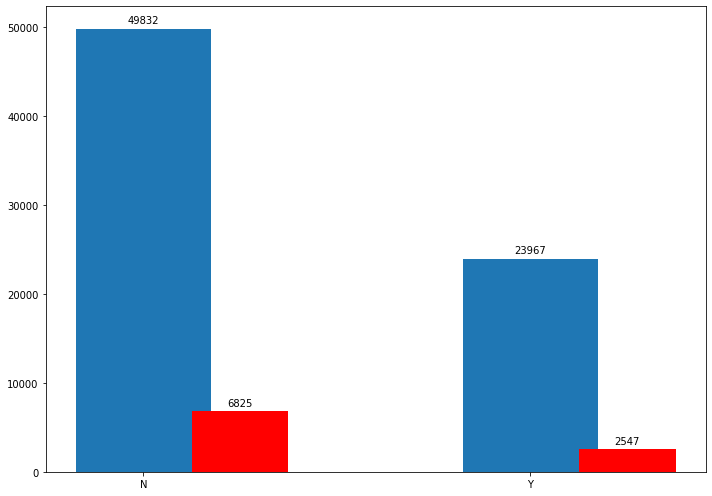

<Figure size 1440x360 with 0 Axes>

Доля дефолта от общего количества 
 N    0.136960
Y    0.106271
Name: car, dtype: float64


In [121]:
bin_plot('car')

sex  car
F    N      0.127560
     Y      0.097393
M    N      0.155151
     Y      0.111337
Name: car, dtype: float64

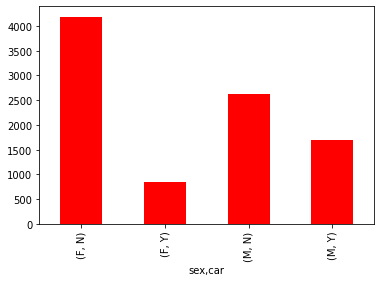

In [122]:
df.query('sample == 1').groupby(['default','sex'])['car'].value_counts()[1].plot.bar(color ='r')
df.query('sample == 1').groupby(['default','sex'])['car'].value_counts()[1]/df.query('sample == 1').groupby(
    ['sex'])['car'].value_counts()

- Клиентов, не имеющих авто, в два раза больше. Из них у 13% наступает дефолт. У людей с авто 10% подвержены дефолту.
- Можно отметить, что женщины с авто менее подвержены дефолту нежели мужчины 

#### car_type

In [123]:
df.car_type.value_counts(), df.car.value_counts()

(N    89140
 Y    21008
 Name: car_type, dtype: int64,
 N    74290
 Y    35858
 Name: car, dtype: int64)

In [124]:
df[df['car_type'] == 'N'].car.value_counts()

N    74290
Y    14850
Name: car, dtype: int64

car_type показывает наличие иномарки, можно заметить, что люди у которых нет авто так же попадают в категорию N. Введем дополнительное значение NN которое будет означать отсутствие авто в признаке car_type

In [125]:
df.loc[df['car'] == 'N','car_type'] = 'NN'

N    0.132744
Y    0.087450
dtype: float64

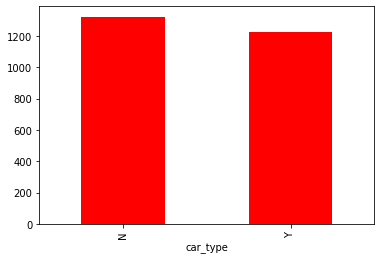

In [126]:
df[(df['sample'] == 1) & (df['car_type'] != 'NN')][['default','car_type']].value_counts()[1].plot.bar(color='r')
df[(df['sample'] == 1) & (df['car_type'] != 'NN')][['default','car_type']].value_counts()[1]/df[(df['sample'] == 1) & (df['car_type'] != 'NN')]['car_type'].value_counts()


Видим. что у 13% людей не имеющих иномарку наступает дефолт и у 8% имеющих иномарку.

#### good_work

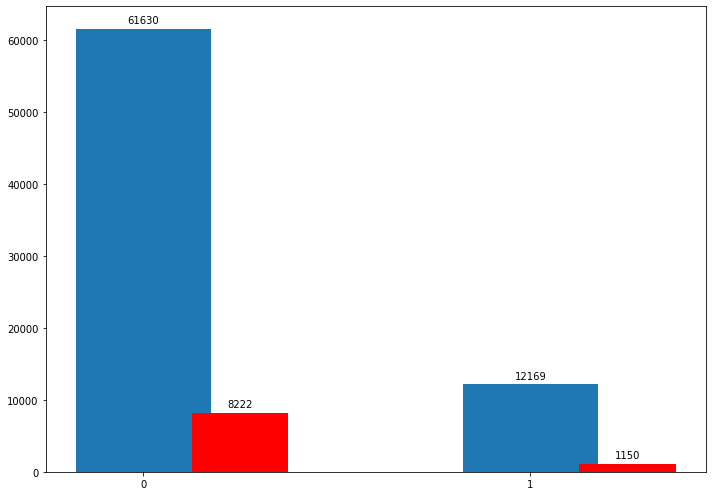

<Figure size 1440x360 with 0 Axes>

Доля дефолта от общего количества 
 0    0.133409
1    0.094502
Name: good_work, dtype: float64


0    91917
1    18231
Name: good_work, dtype: int64

In [127]:
bin_plot('good_work')
df.good_work.value_counts()

У 9% людей с 'хорошей' работой наступает дефолт.

#### foreign_passport

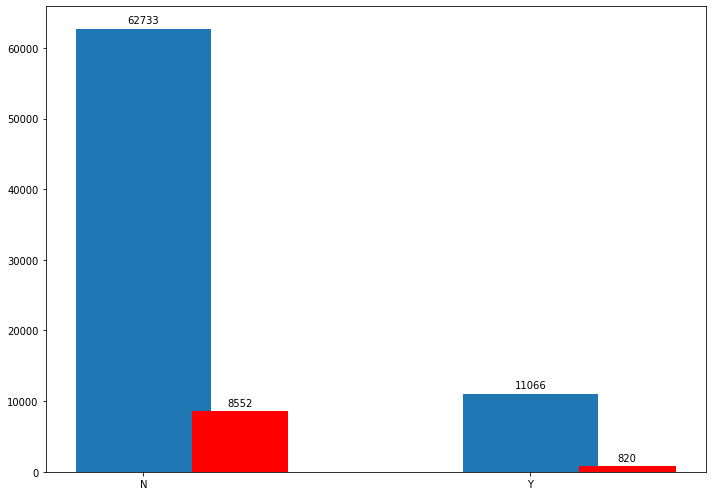

<Figure size 1440x360 with 0 Axes>

Доля дефолта от общего количества 
 N    0.136324
Y    0.074101
Name: foreign_passport, dtype: float64


In [128]:
bin_plot('foreign_passport')


У людей с загран паспортом реже наступает дефолт.

### age


(21, 72)

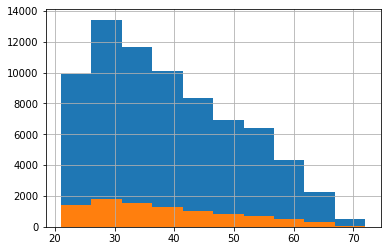

In [129]:
df[df['sample']==1].age.hist()
df[(df['sample']==1)&(df['default']== 1)].age.hist()
df.age.min(),df.age.max()


<AxesSubplot:xlabel='default', ylabel='age'>

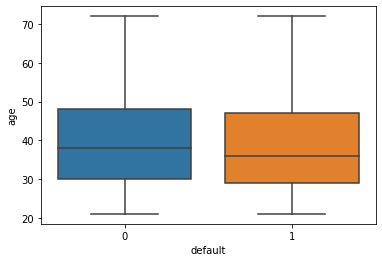

In [130]:
sns.boxplot(x='default', y='age', data=df[df['sample']==1])

Люди старшего возраста менее подвержены дефолту

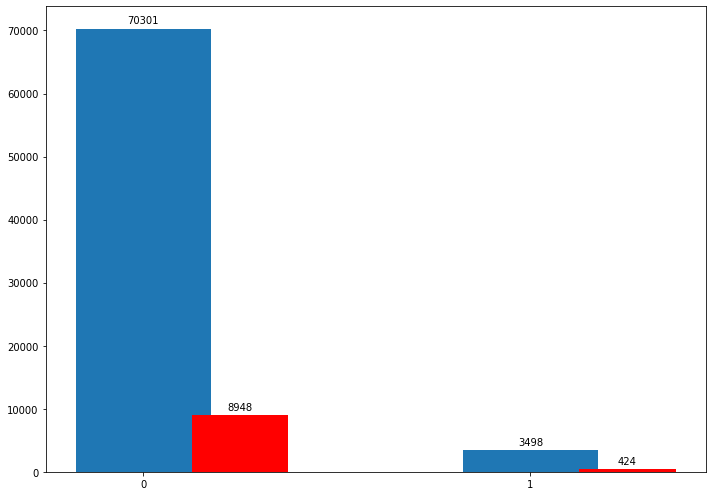

<Figure size 1440x360 with 0 Axes>

Доля дефолта от общего количества 
 0    0.127281
1    0.121212
Name: pensioner, dtype: float64


In [131]:
# сгенерируем признак пенсионер да == 1 , нет == 0
df['pensioner'] = 1
df.loc[(df['age']<60)&(df.sex == 'F'),'pensioner'] = 0
df.loc[(df['age']<65)&(df.sex == 'M'),'pensioner'] = 0
df['pensioner'].value_counts()
bin_plot('pensioner')

Процент дефолта по pensioner практически одинаков

Классифицируем возраст по ВОЗ<br> Классификацией Всемирной организации здравоохранения установлено: <br>18 - 44 лет - молодой возраст == 0, <br>45 - 59 лет - средний возраст == 1;<br> 60 - 74 года - пожилой возраст == 2

In [132]:
df['age_class'] = df.age.apply(lambda x: 0 if 18<x<=44 else 1 if 44<x<=59 else 2)
df['age_class'].value_counts()

0    75485
1    28303
2     6360
Name: age_class, dtype: int64

In [133]:
(df[(df['sample']==1)&(df['default']==1)].age_class.value_counts()/df[(df['sample']==1)].age_class.value_counts(
    )).sort_values()

1    0.113810
2    0.126286
0    0.132032
Name: age_class, dtype: float64

In [134]:
df.query('default != -1').groupby(['default','sex']).age_class.value_counts()

default  sex  age_class
0        F    0            22982
              1            10734
              2             2807
         M    0            20820
              1             6155
              2              929
1        F    0             3333
              1             1331
              2              375
         M    0             3330
              1              838
              2              165
Name: age_class, dtype: int64

Больше всего не отдают кредит люди в возрасте от 18-44

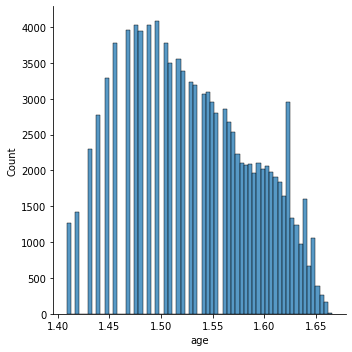

In [135]:
# Логарифмируем признак
df.age = np.log1p(df.age)
sns.displot(np.log1p(df.age))

### decline_app_cnt
количество отказанных прошлых заявок

In [136]:
df.decline_app_cnt.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
15        1
19        1
20        1
21        1
22        1
24        1
30        1
33        1
Name: decline_app_cnt, dtype: int64

Преимущественно в данных присутствуют люди не имеющие отказов в прошлом

In [137]:
# Посмотрим на ппроцент дефолта по отношению к отказам в прошлом

(df[(df['sample']==1)&(df['default']== 1)].decline_app_cnt.value_counts()/df[(df['sample']==1)].decline_app_cnt.value_counts()).sort_values()



0     0.109534
1     0.187805
2     0.243517
5     0.260606
3     0.273533
4     0.289855
7     0.291667
6     0.300885
11    0.333333
9     0.375000
10    0.454545
14    0.500000
8     0.526316
15    1.000000
19    1.000000
22    1.000000
12         NaN
13         NaN
16         NaN
24         NaN
33         NaN
Name: decline_app_cnt, dtype: float64

Очивидно, что с ростом кол-ва отказов в прошлом растет и процент дефолта

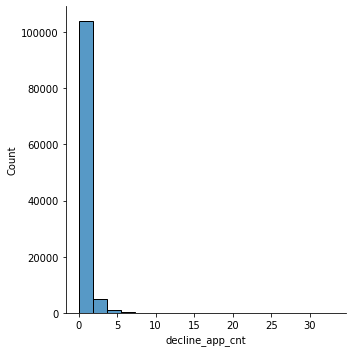

In [138]:
# Посмотрим на распределение
sns.displot(df.decline_app_cnt)

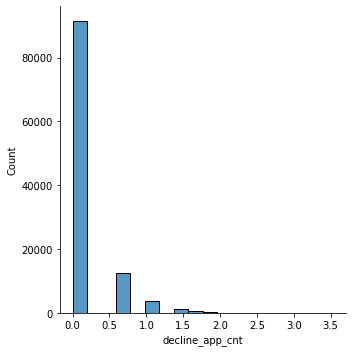

In [139]:
# Логарифмируем
sns.displot(np.log1p(df.decline_app_cnt))

In [140]:
df['decline_app_cnt'] = np.log1p(df.decline_app_cnt)

### score_bki
скоринговый балл по данным из БКИ

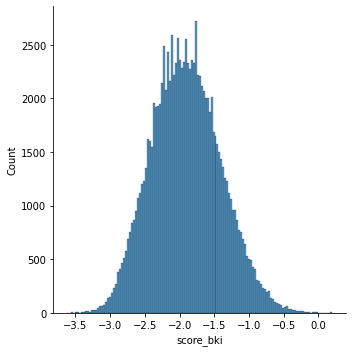

In [141]:
# Посмотрим на рапределение
sns.displot(df['score_bki'])

### bki_request_cnt
количество запросов в БКИ

In [142]:
df[(df['sample']==1)].bki_request_cnt.value_counts()

0     19381
1     18276
2     13749
3      9187
4      5627
5      3268
6      1704
7       852
8       508
9       299
10      225
11      188
12      144
13       94
14       86
15       54
16       35
18       22
17       19
19       18
21       12
24       11
20        9
23        7
22        4
28        4
25        2
26        2
27        2
32        2
41        1
46        1
45        1
29        1
36        1
34        1
33        1
53        1
Name: bki_request_cnt, dtype: int64

In [143]:
(df[(df['sample']==1)&(df['default']==1)].bki_request_cnt.value_counts()/df[(df['sample']==1)].bki_request_cnt.value_counts(
    )).sort_values()

0     0.094990
1     0.118790
2     0.132373
3     0.145641
4     0.151235
7     0.157277
6     0.163732
19    0.166667
5     0.169523
10    0.177778
14    0.186047
8     0.192913
9     0.193980
11    0.244681
21    0.250000
28    0.250000
12    0.256944
16    0.257143
24    0.272727
13    0.276596
15    0.277778
18    0.363636
17    0.368421
23    0.428571
20    0.444444
32    0.500000
27    1.000000
45    1.000000
29    1.000000
41    1.000000
46    1.000000
22         NaN
25         NaN
26         NaN
33         NaN
34         NaN
36         NaN
53         NaN
Name: bki_request_cnt, dtype: float64

Можно сказать , что с ростом кол-ва запросов растет процент дефолта

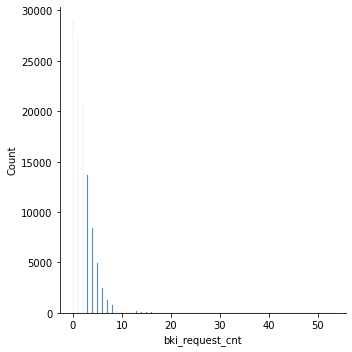

In [144]:
# Посмотрим на рапределение
sns.displot(df['bki_request_cnt'])

<AxesSubplot:>

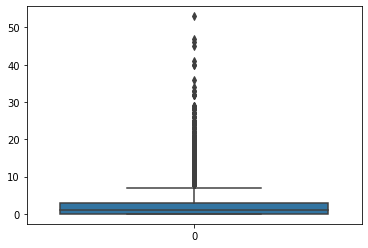

In [145]:
sns.boxplot(data = df.bki_request_cnt)

Есть выбросы, но предположим что это достоверные данные

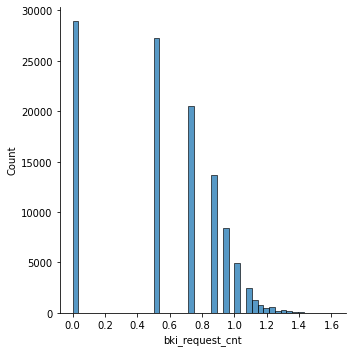

In [146]:
df['bki_request_cnt'] = np.log1p(df['bki_request_cnt'])
sns.displot(np.log1p(df['bki_request_cnt']))

### region_rating
 рейтинг региона

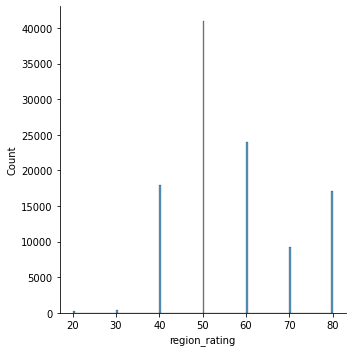

In [147]:
sns.displot(df['region_rating'], kde = False, rug=False)

<AxesSubplot:>

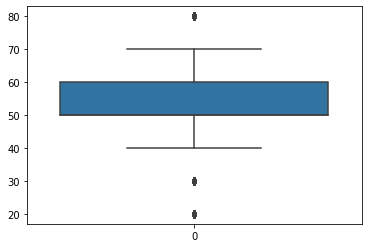

In [148]:
sns.boxplot(data = df.region_rating)

In [149]:
(df[(df['sample']==1)&(df['default']==1)].region_rating.value_counts()/df[(df['sample']==1)].region_rating.value_counts(
    )).sort_values()

80    0.073154
70    0.092434
60    0.128834
50    0.136141
40    0.169702
30    0.190000
20    0.213592
Name: region_rating, dtype: float64

Сложно судить, что имеется ввиду под рейтингом региона в данном случае. Но наиболее рискованые код 2, 3, 4

In [150]:
df.region_rating.value_counts()
# разделим на 10
df['region_rating'] = df.region_rating/10

### home_address, work_address


<AxesSubplot:>

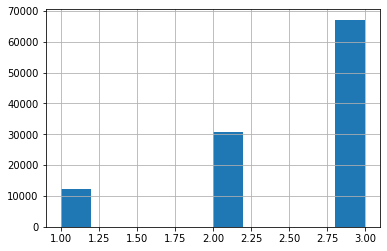

In [151]:
df.work_address.hist()

In [152]:
(df[(df['sample']==1)&(df['default']==1)].work_address.value_counts()/df[(df['sample']==1)].work_address.value_counts(
    )).sort_values()

1    0.074154
2    0.102507
3    0.147957
Name: work_address, dtype: float64

<AxesSubplot:>

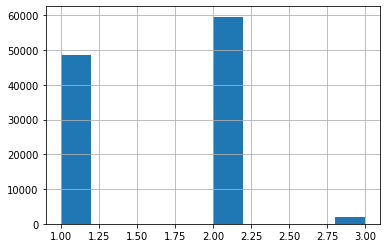

In [153]:
df.home_address.hist()

In [154]:
(df[(df['sample']==1)&(df['default']==1)].home_address.value_counts()/df[(df['sample']==1)].home_address.value_counts(
    )).sort_values()

1    0.092896
3    0.116057
2    0.155146
Name: home_address, dtype: float64

### income
доход заемщика

(1000, 1000000, 30000.0, 41012.648536514505)

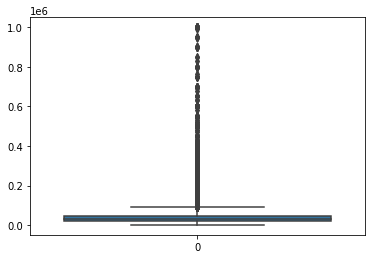

In [155]:
sns.boxplot(data=df.income)
df.income.min(),df.income.max(),df.income.median(),df.income.mean()

(2358, 24)

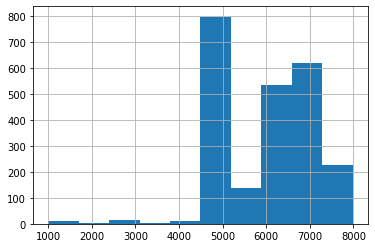

In [156]:
df[df.income < 8000].income.hist()
df[df.income < 8000].shape

Видим, что есть мин доход 1000, если высокий доход логически объясним, то доходы ниже прожиточного минимума выглядят подозрительно.<br>
Однако, не известно в какой валюте представленны данные и за какой период.<br>
Оставим как есть

Доход примем за достоверную информацию. <br> 
Классифицируем доход как <br>
низкий == 0<br>
ниже среднего == 1<br>
средний == 2<br>
выше среднего == 3<br>
высокий = 4<br>
сверх доход = 5<br>

In [157]:
IQR = df.income.quantile(0.75) - df.income.quantile(0.25)
l = df.income.quantile(0.25)-1.5*IQR
r = df.income.quantile(0.75)+ 1.5*IQR
n = df.income.quantile(0.75)+ 10*IQR
print('Низкий : < ',df.income.quantile(0.25),'\n',
      'Ниже среднего : от',df.income.quantile(0.25),' до ',IQR,'\n',
      'Средний : от',IQR,' до ',df.income.quantile(0.75),'\n',
      'Выше среднего : от',df.income.quantile(0.75),' до ',r,'\n',
     'Высокий : от',r,' до ',n,'\n',
     'Сверх доход : >', n)

Низкий : <  20000.0 
 Ниже среднего : от 20000.0  до  28000.0 
 Средний : от 28000.0  до  48000.0 
 Выше среднего : от 48000.0  до  90000.0 
 Высокий : от 90000.0  до  328000.0 
 Сверх доход : > 328000.0


In [158]:
p_1 = df.income.quantile(0.25)
p_2 = df.income.quantile(0.75)



df['income_class'] = df.income.apply(lambda x: 0 if x <= p_1 else 
                                    1 if p_1< x <= IQR else
                                    2 if IQR < x <= p_2 else
                                    3 if p_2 < x <= r else
                                    4 if r < x <= n else
                                    5 if x > n else x)

In [159]:
print(df['income_class'].value_counts())

2    33807
0    31975
3    20344
1    17022
4     6620
5      380
Name: income_class, dtype: int64


In [160]:
(df[(df['sample']==1)&(df['default']==1)].income_class.value_counts()/df[(df['sample']==1)].income_class.value_counts(
    )).sort_values()

4    0.084104
3    0.095340
5    0.103846
2    0.126484
1    0.145556
0    0.146850
Name: income_class, dtype: float64

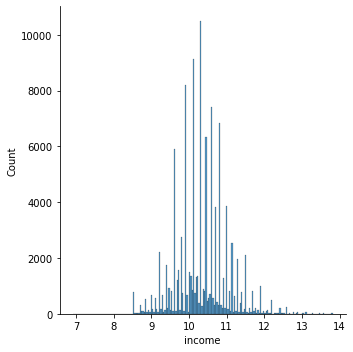

In [161]:
# Логарифмируем
df['income'] = np.log1p(df.income)
sns.displot(df['income'])

### sna
связь заемщика с клиентами банка

<AxesSubplot:>

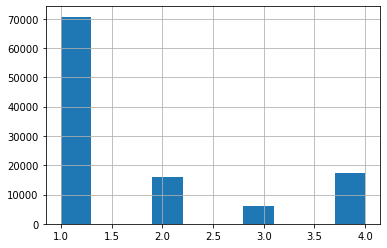

In [162]:
df.sna.hist()

In [163]:
(df[(df['sample']==1)&(df['default']==1)].sna.value_counts()/df[(df['sample']==1)].sna.value_counts(
    )).sort_values()

1    0.098201
2    0.149821
3    0.157652
4    0.211507
Name: sna, dtype: float64

### first_time
давность наличия информации о заемщике

<AxesSubplot:>

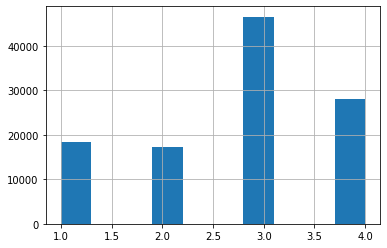

In [164]:
df.first_time.hist()

<AxesSubplot:>

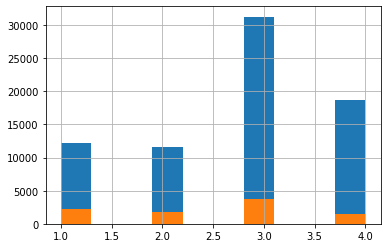

In [165]:
df[df['sample']==1].first_time.hist()
df[(df['sample']==1)&(df['default']==1)].first_time.hist()

In [166]:
(df[(df['sample']==1)&(df['default']==1)].first_time.value_counts()/df[df['sample']==1].first_time.value_counts()
).sort_values()

4    0.082030
3    0.120269
2    0.155429
1    0.186126
Name: first_time, dtype: float64

Меньше всего процент дефолта в категории 4, 1 - наиболее рискованная группа

0    64427
1     9372
Name: default, dtype: int64

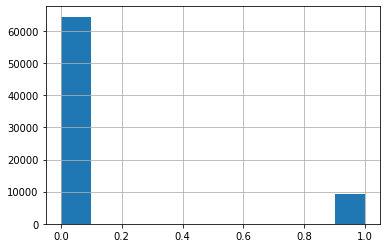

In [167]:
# Целевой признак
df.query('sample ==1').default.hist()
df.query('sample ==1').default.value_counts()

- Видим дисбаланс, меньшенство приближается 1/10 от выборки <br>
  Учтем этот факт <br>


### Предварительный итог


- sex: Процент дефолта практически не зависит от пола
- car: Люди не имеющие авто более подвержены дефолту (N)
- car_type: Имеющие машину, но не иномарку более подвержены дефолту (N)
- good_work: Люди с "плохой" работой более подвержены дефолту (0)
- foreign_passport: Не имеющие загран паспорта более подвержены дефолту (N)
- age: Люди в возрасте от 18 до 44 более подвержены дефолту age_class == (0)
- pensioner: Процент дефолта практически не зависит
- decline_app_cnt: с ростом кол-ва отказов в прошлом растет и процент дефолта
- bki_request_cnt: с ростом кол-ва запросов растет процент дефолта
- region_rating: наиболее рискованые регионы с кодом 2, 3, 4
- work_address: наиболее рискован код 3
- home_address: наиболее рискован код 2
- income: наиболее рискованные заемщики с доходом менее 28000 income_class == (0,1)
- sna: наиболее рискован код 4
- first_time: наиболее рискован код 1

### Подготовим данные к заполнению пропусков в education

In [168]:
# Удалим колонку с datetime
df = df.drop('app_date',axis=1)

In [169]:
# Добавим сгенерированные бинарные переменные
for i in df:
    if len(df[i].value_counts()) == 2 and i != 'sample':
        if i not in bin_cat:
            bin_cat.append(i)
bin_cat

['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'pensioner']

In [170]:
# Категориальные переменные
categ_val =[]
for i in df:
    if len(df[i].value_counts()) < 13 and (i != 'sample' and i!='default'):
        if i not in bin_cat:
            categ_val.append(i)
            print(i)

education
region_rating
home_address
work_address
sna
first_time
date_month
date_week
age_class
income_class


In [171]:
# Числовые переменные
var_val =[]
for i in df:
    if len(df[i].value_counts()) > 13 and (i != 'sample' and i!='default'):
        if i not in bin_cat and i not in categ_val:
            var_val.append(i)
            print(i)

age
decline_app_cnt
score_bki
bki_request_cnt
income
date_date


In [172]:
print('Итого :','\n',
     'Бинарные :',len(bin_cat),'\n',
     'Категориальные :', len(categ_val),'\n',
     'Числовые :',len(var_val))

Итого : 
 Бинарные : 6 
 Категориальные : 10 
 Числовые : 6


###  Преобразуем бинарные признаки с помощью LabelEncoder


In [173]:
# Преобразуем бинарные признаки с помощью LabelEncoder
le = LabelEncoder()
for i in df.drop('education',axis=1):
    if df[i].dtype == 'object':
        df[i] = le.fit_transform(df[i])
        print(dict(enumerate(le.classes_)))

{0: 'F', 1: 'M'}
{0: 'N', 1: 'Y'}
{0: 'N', 1: 'NN', 2: 'Y'}
{0: 'N', 1: 'Y'}


# Проработаем пропуски
Попытаемся предсказать значения education

In [174]:
df_nan_train = df.dropna()
le = LabelEncoder() # перекодируем 
df_nan_train['education'] = le.fit_transform(df_nan_train.education)
print(dict(enumerate(le.classes_)))

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [175]:
# посмотрим на распределение education
df_nan_train.education.value_counts()

3    57998
1    34768
4    14748
2     1865
0      291
Name: education, dtype: int64

Явный дисбаланс переменных выровняем education == 3,1,4 по 4<br>


In [176]:
# Выберем рандомно индексы с параметрами 1,3
a = np.array(df_nan_train.query('education == 3').index)
b = np.array(df_nan_train.query('education == 1').index)
#c = np.array(df_nan_train.query('education == 4').index)
a_3 = np.random.choice(a, size=round(len(df_nan_train.query(
    'education == 3').education)*0.7), replace=False, p=None)
a_1 = np.random.choice(b, size=round(len(df_nan_train.query(
    'education == 1').education)/2), replace=False, p=None)
#
df_nan_train = df_nan_train.drop(index= np.concatenate((a_3,a_1)))
df_nan_train.education.value_counts()

3    17399
1    17384
4    14748
2     1865
0      291
Name: education, dtype: int64

In [177]:
X_nan = df_nan_train.drop(['education','sample','default'],axis=1)
y_nan = df_nan_train.education

In [178]:
# Разбивка
valid_frac = 0.15
test_frac = 0.15

valid_count = int(valid_frac * df_nan_train.shape[0])
test_count = int(test_frac * df_nan_train.shape[0])

X_train, X_valid_test, y_train, y_valid_test = train_test_split(X_nan,y_nan,
                                     test_size=(valid_count + test_count),random_state = 42)
X_valid, X_test,y_valid,y_test = train_test_split(X_valid_test,y_valid_test, test_size=test_count,random_state = 42)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((36181, 21), (7753, 21), (7753, 21), (36181,), (7753,), (7753,))

In [179]:
scaler = StandardScaler()
X_train_nan = scaler.fit_transform(X_train)
X_valid_nan = scaler.transform(X_valid)
X_test_nan = scaler.transform(X_test)

In [180]:
model_nan = LogisticRegression(random_state = 42,multi_class = 'multinomial',max_iter = 10000)
model_nan.fit(X_train_nan, y_train)


y_pred_ss = model_nan.predict(X_valid_nan)

print(classification_report(y_valid,y_pred_ss,zero_division=0))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.50      0.59      0.54      2622
           2       0.00      0.00      0.00       243
           3       0.52      0.58      0.54      2674
           4       0.45      0.36      0.40      2165

    accuracy                           0.50      7753
   macro avg       0.29      0.30      0.30      7753
weighted avg       0.47      0.50      0.48      7753



In [181]:

y_pred_ss = model_nan.predict(X_test_nan)

print(classification_report(y_test,y_pred_ss,zero_division=0))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.48      0.58      0.53      2540
           2       0.00      0.00      0.00       289
           3       0.53      0.60      0.57      2667
           4       0.46      0.34      0.39      2219

    accuracy                           0.50      7753
   macro avg       0.29      0.31      0.30      7753
weighted avg       0.47      0.50      0.48      7753



In [182]:
# Рандомное заполнение пропусков
y_pred_rand = np.random.randint(0, 5, y_valid.shape[0])
print(classification_report(y_valid,y_pred_rand))

              precision    recall  f1-score   support

           0       0.01      0.20      0.01        49
           1       0.35      0.20      0.26      2622
           2       0.03      0.17      0.05       243
           3       0.35      0.20      0.25      2674
           4       0.27      0.20      0.23      2165

    accuracy                           0.20      7753
   macro avg       0.20      0.20      0.16      7753
weighted avg       0.32      0.20      0.24      7753



Модель не идеальна, но все же лучше рандомного заполнения, применим ее

In [183]:
X_pred_nan = df[df.education.isna()].drop(['education','sample','default'],axis=1)
X_pred_nan_ss = scaler.transform(X_pred_nan)

In [184]:
y_pred_education = model_nan.predict(X_pred_nan_ss)

In [185]:
y_pred_education.shape, df[df.education.isna()].shape

((478,), (478, 24))

In [186]:
#  Заполним пропуски предсказанным значением
n=0
for i in df[df.education.isna()].index:
    df.loc[i,'education']=y_pred_education[n]
    n+=1

In [187]:
df.education = df.education.apply(lambda x: 0 if x== 'ACD' else   1 if x== 'GRD' else  2 if x== 'PGR' else 3
                                  if x=='SCH' else  4 if x== 'UGR' else x)

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   education         110148 non-null  int64  
 1   sex               110148 non-null  int64  
 2   age               110148 non-null  float64
 3   car               110148 non-null  int64  
 4   car_type          110148 non-null  int64  
 5   decline_app_cnt   110148 non-null  float64
 6   good_work         110148 non-null  int64  
 7   score_bki         110148 non-null  float64
 8   bki_request_cnt   110148 non-null  float64
 9   region_rating     110148 non-null  float64
 10  home_address      110148 non-null  int64  
 11  work_address      110148 non-null  int64  
 12  income            110148 non-null  float64
 13  sna               110148 non-null  int64  
 14  first_time        110148 non-null  int64  
 15  foreign_passport  110148 non-null  int64  
 16  sample            11

# Посмотрим на корреляцию

In [189]:
df[var_val + ['default']].corr()

,age,decline_app_cnt,score_bki,bki_request_cnt,income,date_date,default
age,1.000000,-0.128624,-0.109169,0.050241,-0.090734,0.006185,-0.006285
decline_app_cnt,-0.128624,1.000000,0.207342,0.127531,-0.013959,-0.004745,0.050573
score_bki,-0.109169,0.207342,1.000000,0.141600,0.002592,-0.000370,0.065020
bki_request_cnt,0.050241,0.127531,0.141600,1.000000,0.078649,0.005428,0.027933
income,-0.090734,-0.013959,0.002592,0.078649,1.000000,-0.014890,-0.020028
date_date,0.006185,-0.004745,-0.000370,0.005428,-0.014890,1.000000,-0.001333
default,-0.006285,0.050573,0.065020,0.027933,-0.020028,-0.001333,1.000000


<AxesSubplot:>

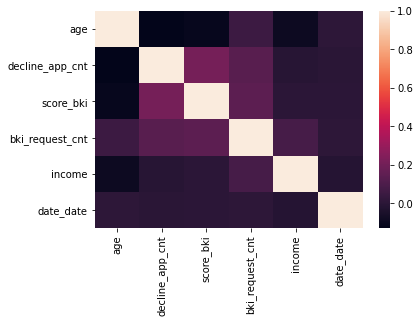

In [190]:
sns.heatmap(df[var_val].corr())

Сильной корреляции между числовыми признаками не обнаружено

### Посмотрим на значимость признаков

<AxesSubplot:>

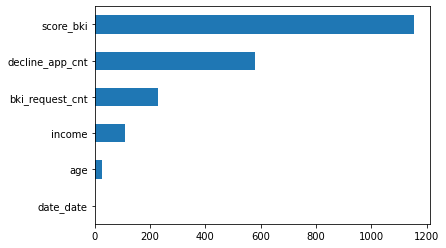

In [191]:
# Построим график важности числовых переменных
imp_num = pd.Series(f_classif(df[var_val], df.default)[0],index=var_val)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

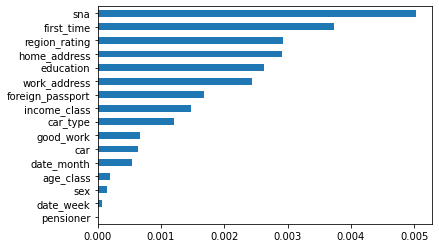

In [192]:

imp_cat = Series(mutual_info_classif(df[bin_cat + categ_val], df['default'],
                                     discrete_features =True), index = bin_cat + categ_val)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# Data Preprocessing

In [193]:
# Разделим ранее объединенный датасет
X_data_train = df[df['sample'] == 1].drop(['sample','default'],axis=1)
y_data_train = df[df['sample'] == 1].default
data_test = df[df['sample'] == 0].drop(['default','sample'],axis=1)

Бинарные признаки мы перекодировали, преобразуем категориальные.

In [194]:
X_cat = OneHotEncoder(sparse = False).fit_transform(X_data_train[list(set(categ_val))].values)
X_cat.shape

(73799, 46)

Соеденим

In [195]:
X = np.hstack([X_data_train[list(set(X_data_train.columns.tolist()) - set(categ_val))], X_cat])
X.shape
y = y_data_train.values
X.shape, y.shape

((73799, 58), (73799,))

In [196]:
y = y_data_train.values
#undersample = NearMiss(version=1, n_neighbors=3)
#X_undr_smpl, y_undr_smpl = undersample.fit_resample(X, y)

#print(Counter(y_undr_smpl), X_undr_smpl.shape, y_undr_smpl.shape)

Данные перекодированы и сбалансированы. Делаем разбивку по Hold-out
 train,valid,test (70/15/15)

In [197]:
valid_frac = 0.15
test_frac = 0.15

valid_count = int(valid_frac * X.shape[0])
test_count = int(test_frac * X.shape[0])

X_train, X_valid_test, y_train, y_valid_test = train_test_split(X,y,
                                     test_size=(valid_count + test_count),random_state = 42)
X_valid, X_test,y_valid,y_test = train_test_split(X_valid_test,y_valid_test, test_size=test_count,random_state = 42)

In [198]:
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_valid_ss = scaler.transform(X_valid)
X_test_ss = scaler.transform(X_test)

[[9607   44]
 [1385   33]]
0.74034


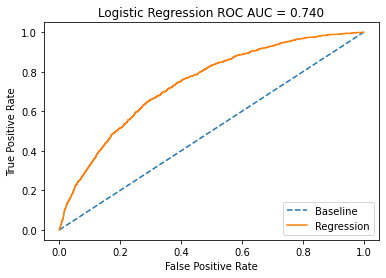

In [199]:
model = LogisticRegression(max_iter = 5000,random_state =42)
model.fit(X_train_ss, y_train)

probs = model.predict_proba(X_valid_ss)[:, 1]
y_pred = model.predict(X_valid_ss)

print(confusion_matrix(y_valid, y_pred))
print(round(roc_auc_score(y_valid,probs),5))
roc_auc_print(y_valid,probs)

[[9648   59]
 [1316   46]]
0.73812


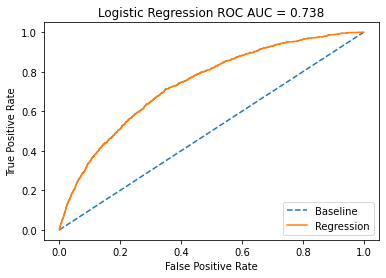

In [200]:
probs = model.predict_proba(X_test_ss)[:, 1]
y_pred = model.predict(X_test_ss)
print(confusion_matrix(y_test, y_pred))
print(round(roc_auc_score(y_test,probs),5))
roc_auc_print(y_test,probs)

Настроим гипперпараметры

In [ ]:
from sklearn.model_selection import GridSearchCV

# Создадим гиперпараметры
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'saga'], 
     'class_weight':[None, 'balanced'], 
     'multi_class': ['auto','ovr'],
    } ,
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':[None, 'balanced'], 
     'multi_class': ['auto','ovr'],
    }, 
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}]


# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, param_grid, cv=5, scoring='f1',n_jobs=-1)

best_model = clf.fit(X_train_ss, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Лучшее solver:', best_model.best_estimator_.get_params()['solver'])
print('Лучшее class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print('Лучшее multi_class:', best_model.best_estimator_.get_params()['multi_class'])

In [ ]:
estimator = best_model.best_estimator_
estimator.get_params()

y_pred = estimator.predict(X_valid_ss)
probs = estimator.predict_proba(X_valid_ss)[:, 1]

print(confusion_matrix(y_valid, y_pred))
print(round(roc_auc_score(y_valid,probs),5))
roc_auc_print(y_valid,probs)

In [ ]:
y_pred = estimator.predict(X_test_ss)
probs = estimator.predict_proba(X_test_ss)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(round(roc_auc_score(y_test,probs),5))
roc_auc_print(y_test,probs)

Настройки гипперпараметра показатель roc_auc особо не улучшил, но распределение по confusion_matrix улучшилось.

In [201]:
from sklearn.svm import LinearSVC

from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter = 10000).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

(73799, 37)

In [202]:
valid_count = int(valid_frac * X_new.shape[0])
test_count = int(test_frac * X_new.shape[0])

X_train_SVC, X_valid_test, y_train, y_valid_test = train_test_split(X_new,y,
                                     test_size=(valid_count + test_count),random_state = 42)
X_valid_SVC, X_test_SVC,y_valid,y_test = train_test_split(X_valid_test,y_valid_test, test_size=test_count,random_state = 42)

In [203]:
scaler = StandardScaler()
X_train_CV = scaler.fit_transform(X_train_SVC)
X_valid_CV = scaler.transform(X_valid_SVC)
X_test_CV = scaler.transform(X_test_SVC)

[[6443 3208]
 [ 444  974]]
0.74029


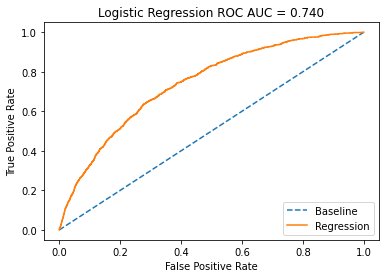

In [204]:
from sklearn.linear_model import LogisticRegressionCV
model_LRCV = LogisticRegressionCV(max_iter = 50000,random_state =42, cv=5,scoring='f1',class_weight ='balanced',
                                  dual=False,solver='saga',n_jobs = -1,penalty ='l2',Cs=[1, 10, 100, 1000],refit=True)
model_LRCV.fit(X_train_CV, y_train)

probs = model_LRCV.predict_proba(X_valid_CV)[:, 1]
y_pred = model_LRCV.predict(X_valid_CV)

print(confusion_matrix(y_valid, y_pred))
print(round(roc_auc_score(y_valid,probs),5))
roc_auc_print(y_valid,probs)

[[6494 3213]
 [ 424  938]]
0.74046


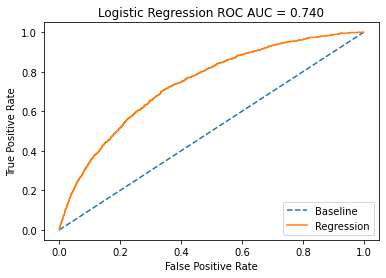

In [205]:
probs = model_LRCV.predict_proba(X_test_CV)[:, 1]
y_pred = model_LRCV.predict(X_test_CV)

print(confusion_matrix(y_test, y_pred))
print(round(roc_auc_score(y_test,probs),5))
roc_auc_print(y_test,probs)

In [207]:
X_data_test = data_test
X_dt_cat = OneHotEncoder(sparse = False).fit_transform(X_data_test[list(set(categ_val))].values)
X_dt_cat.shape

(36349, 46)

In [208]:
X_dt = np.hstack([X_data_test[list(set(X_data_test.columns.tolist()) - set(categ_val))], X_dt_cat])
X_new = model.transform(X_dt)
X_new.shape


(36349, 37)

In [209]:
X_dt_ss = scaler.fit_transform(X_new)
X_dt_ss.shape

(36349, 37)

In [210]:
y_proba = model_LRCV.predict_proba(X_dt_ss)[:, 1]

In [211]:
y_proba.shape

(36349,)

In [212]:
df_result = pd.DataFrame(df_test['client_id'])
df_result['default']=y_proba
df_result

,client_id,default
0,74835,0.201746
1,17527,0.770158
2,75683,0.294146
3,26883,0.411680
4,28862,0.151589
...,...,...
36344,83775,0.809429
36345,106254,0.113000
36346,81852,0.784982
36347,1971,0.584119


In [213]:
df_result.to_csv('submission_1.csv', index=False)